In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud

In [86]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv("Predict Hair Fall.csv")

In [88]:
df.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [89]:
print(df.shape)

(999, 13)


In [90]:
df.nunique()

Id                           995
Genetics                       2
Hormonal Changes               2
Medical Conditions            11
Medications & Treatments      11
Nutritional Deficiencies      11
Stress                         3
Age                           33
Poor Hair Care Habits          2
Environmental Factors          2
Smoking                        2
Weight Loss                    2
Hair Loss                      2
dtype: int64

In [91]:
df.isnull().sum()

Id                           0
Genetics                     0
Hormonal Changes             0
Medical Conditions           0
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64

In [92]:
df.duplicated().sum()

0

In [93]:
df.dtypes

Id                            int64
Genetics                     object
Hormonal Changes             object
Medical Conditions           object
Medications & Treatments     object
Nutritional Deficiencies     object
Stress                       object
Age                           int64
Poor Hair Care Habits        object
Environmental Factors        object
Smoking                      object
Weight Loss                  object
Hair Loss                     int64
dtype: object

In [94]:
numerical_columns=df.select_dtypes(include=['int64']).columns
categorical_columns=df.select_dtypes(include=['object']).columns

In [95]:
numerical_columns

Index(['Id', 'Age', 'Hair Loss'], dtype='object')

In [96]:
categorical_columns

Index(['Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss '],
      dtype='object')

In [97]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['Id', 'Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Age', 'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss ', 'Hair Loss'],
      dtype='object')


In [98]:
df.describe()

,Id,Age,Hair Loss
count,999.000000,999.000000,999.000000
mean,153354.673674,34.188188,0.497497
std,25516.041985,9.377980,0.500244
min,110003.000000,18.000000,0.000000
25%,131867.500000,26.000000,0.000000
50%,152951.000000,34.000000,0.000000
75%,174969.000000,42.000000,1.000000
max,199949.000000,50.000000,1.000000


In [99]:
# Function to identify outliers in numerical columns
def identify_numerical_outliers(df, numerical_columns, contamination=0.05, random_state=42):
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    outliers = iso_forest.fit_predict(df[numerical_columns])
    
    # Mark numerical outliers as True where outliers == -1
    df['numerical_outlier'] = (outliers == -1)
    
    return df

# Function to identify outliers in categorical columns based on frequency threshold
def identify_categorical_outliers(df, categorical_columns, threshold=0.01):
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in categorical_columns:
        freq = df[col].value_counts(normalize=True)
        rare_values = freq[freq < threshold].index
        
        # Mark categorical outliers as True if the value is in the rare list
        outlier_flags[f'{col}_outlier'] = df[col].isin(rare_values)
    
    # Combine all categorical outliers into a single column
    df['categorical_outlier'] = outlier_flags.any(axis=1)
    
    return df


# Identify numerical and categorical columns in the dataset
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical outliers
df = identify_numerical_outliers(df, numerical_columns)

# Identify categorical outliers (e.g., less than 1% frequency)
df = identify_categorical_outliers(df, categorical_columns, threshold=0.01)

# Print results
numerical_outlier_percentage = (df['numerical_outlier'].sum() / len(df)) * 100
categorical_outlier_percentage = (df['categorical_outlier'].sum() / len(df)) * 100

print(f"Percentage of numerical outliers: {numerical_outlier_percentage:.2f}%")
print(f"Percentage of categorical outliers: {categorical_outlier_percentage:.2f}%")


Percentage of numerical outliers: 5.01%
Percentage of categorical outliers: 0.20%


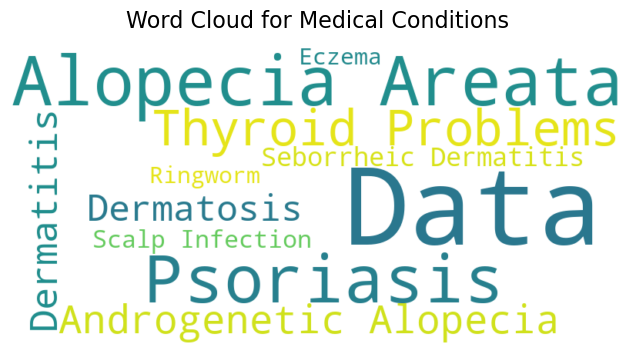

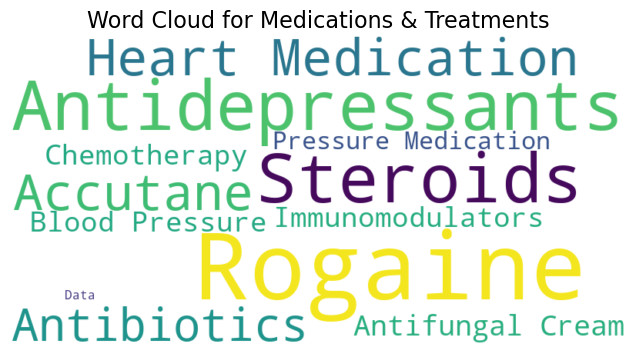

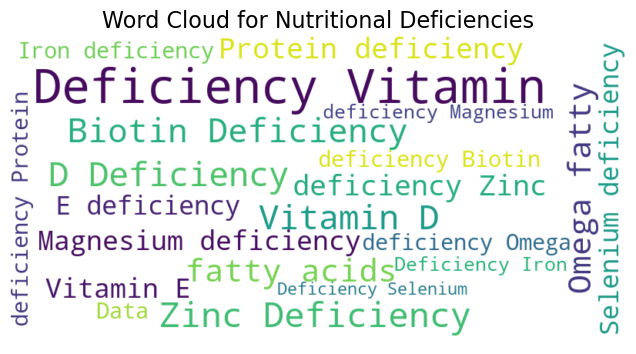

In [101]:
def generate_wordcloud(column_data, title):
    text_data = ' '.join(column_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes for better visualization
    plt.title(title, fontsize=16)
    plt.show()

# Generate word clouds for each of the three variables
generate_wordcloud(df['Medical Conditions'], 'Word Cloud for Medical Conditions')
generate_wordcloud(df['Medications & Treatments'], 'Word Cloud for Medications & Treatments')
generate_wordcloud(df['Nutritional Deficiencies'], 'Word Cloud for Nutritional Deficiencies')


### Basic Data Preprocessing

In [102]:
X = df.drop(['Hair Loss'], axis =1 )
y = df['Hair Loss']

categorical_cols = X.select_dtypes('O').columns.tolist()
numerical_cols = X.select_dtypes(exclude = 'O').columns.tolist()

In [103]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_cols),
         ("StandardScaler", numeric_transformer, numerical_cols),        
    ]
)

In [104]:
X_scaled = preprocessor.fit_transform(X)
X_scaled

<999x52 sparse matrix of type '<class 'numpy.float64'>'
	with 13986 stored elements in Compressed Sparse Row format>

**NOTE:** Based on the domain (healthcare), the dataset's outliers and extreme Numerical feature values are equally important to normal data for Hair Loss Classification. That's why, the outliers are not eliminated and the data are kept consistent with the original dataset.


# Cluster Analysis

In [105]:
from sklearn.model_selection import cross_val_predict, cross_val_score,KFold, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [106]:
df = df.drop(columns=['Id'])

categorical_columns = df.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Display the resulting dataframe after encoding
df_encoded.head()

,Age,Hair Loss,numerical_outlier,categorical_outlier,Genetics_Yes,Hormonal Changes_Yes,Medical Conditions_Androgenetic Alopecia,Medical Conditions_Dermatitis,Medical Conditions_Dermatosis,Medical Conditions_Eczema,...,Nutritional Deficiencies_Vitamin A Deficiency,Nutritional Deficiencies_Vitamin D Deficiency,Nutritional Deficiencies_Vitamin E deficiency,Nutritional Deficiencies_Zinc Deficiency,Stress_Low,Stress_Moderate,Poor Hair Care Habits_Yes,Environmental Factors_Yes,Smoking_Yes,Weight Loss_Yes
0,19,0,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
1,43,0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,True,False,False
2,26,0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,True,True,False,True
3,46,0,False,False,True,True,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
4,30,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,True,False


In [156]:
X = df_encoded.drop(columns=['Hair Loss'])
Y = df_encoded['Hair Loss']
x_train , x_test, y_train , y_test = train_test_split(X,Y,test_size=0.2)

In [157]:
x_train

,Age,numerical_outlier,categorical_outlier,Genetics_Yes,Hormonal Changes_Yes,Medical Conditions_Androgenetic Alopecia,Medical Conditions_Dermatitis,Medical Conditions_Dermatosis,Medical Conditions_Eczema,Medical Conditions_No Data,...,Nutritional Deficiencies_Vitamin A Deficiency,Nutritional Deficiencies_Vitamin D Deficiency,Nutritional Deficiencies_Vitamin E deficiency,Nutritional Deficiencies_Zinc Deficiency,Stress_Low,Stress_Moderate,Poor Hair Care Habits_Yes,Environmental Factors_Yes,Smoking_Yes,Weight Loss_Yes
711,32,False,False,True,True,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,True
143,39,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
255,24,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
258,37,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
782,19,False,False,True,True,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,40,False,False,False,True,False,False,False,False,True,...,False,False,False,True,True,False,False,True,False,True
268,44,False,False,True,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
535,32,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
690,33,False,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,True


## K-Mean

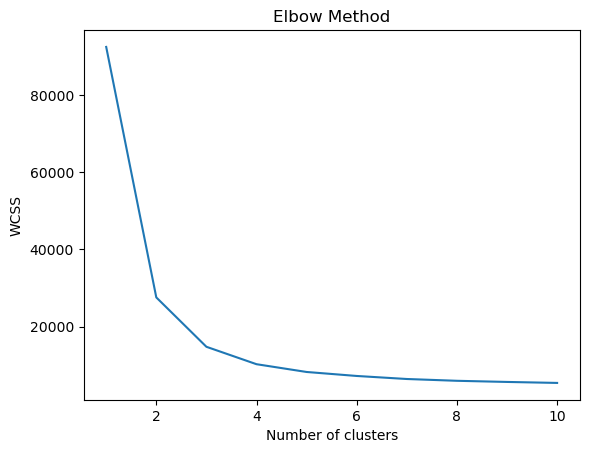

In [171]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [172]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

The average silhouette score is: 0.5569329653622759


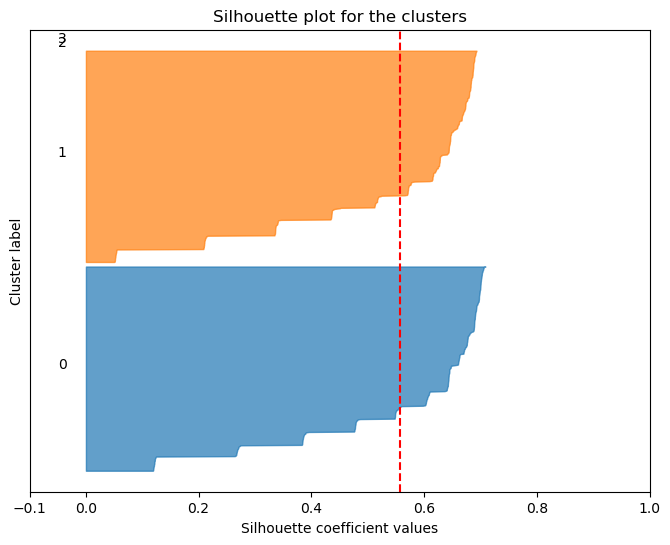

In [175]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
silhouette_avg = silhouette_score(X, cluster_labels)
print("The average silhouette score is:", silhouette_avg)


sample_silhouette_values = silhouette_samples(X, cluster_labels)


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)


cluster_colors = sns.color_palette('tab10', n_colors=4)

y_lower = 10
for i in range(4):  
    
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cluster_colors[i]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    
    y_lower = y_upper + 10  

ax1.set_title("Silhouette plot for the clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [176]:
# Count the number of observations in each cluster
cluster_counts = np.bincount(cluster_labels)

# Print the number of observations in each cluster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} observations")

Cluster 0: 491 observations
Cluster 1: 508 observations


## K-medoids

# Model Fitting

#### XGBoost

Accuracy for Cluster 0: 1.0
Accuracy for Cluster 1: 1.0


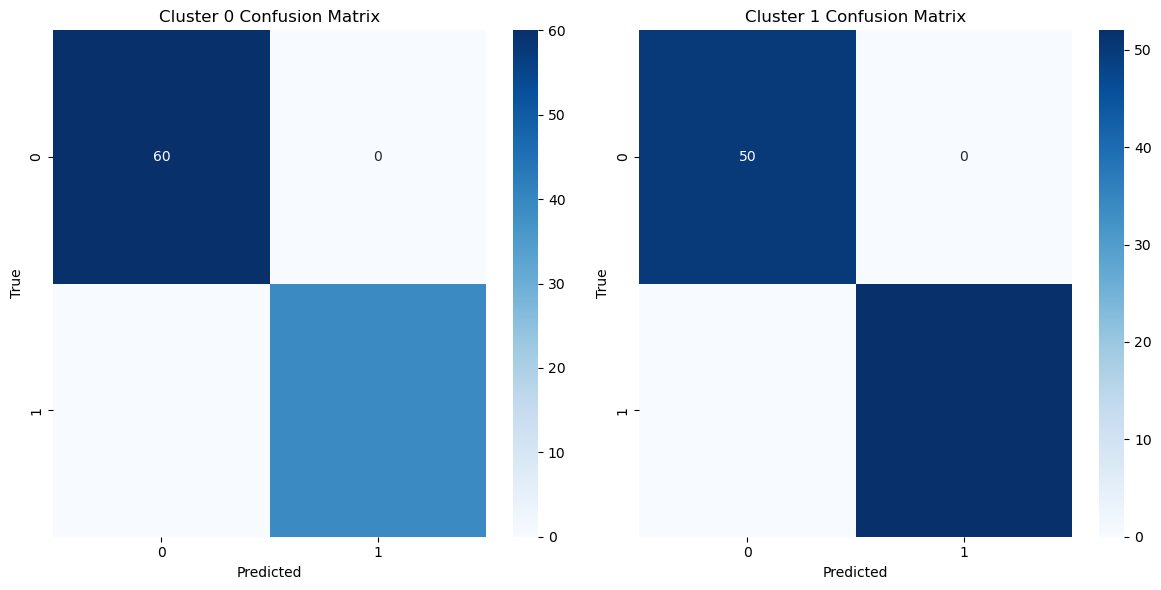

In [179]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cluster_0_data = X[cluster_labels == 0]
cluster_1_data = X[cluster_labels == 1]

cluster_0_target = Y[cluster_labels == 0]
cluster_1_target = Y[cluster_labels == 1]

# Split cluster 0 data into train and test sets
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(cluster_0_data, cluster_0_target, test_size=0.2, random_state=42)

# Split cluster 1 data into train and test sets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(cluster_1_data, cluster_1_target, test_size=0.2, random_state=42)

# Train XGBoost models for each cluster
model_0 = xgb.XGBClassifier(random_state=42)
model_1 = xgb.XGBClassifier(random_state=42)

# Fit the models
model_0.fit(x_train_0, y_train_0)
model_1.fit(x_train_1, y_train_1)

# Predict for cluster 0
y_pred_0 = model_0.predict(x_test_0)
accuracy_0 = accuracy_score(y_test_0, y_pred_0)
print(f"Accuracy for Cluster 0: {accuracy_0}")

# Predict for cluster 1
y_pred_1 = model_1.predict(x_test_1)
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for Cluster 1: {accuracy_1}")

# Plot confusion matrices for both clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_test_0, y_pred_0), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Cluster 0 Confusion Matrix")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(confusion_matrix(y_test_1, y_pred_1), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Cluster 1 Confusion Matrix")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

